# Evaluation of a selection of models on 60km -> 2.2km-4x over Birmingham in a low data scenario

In [ ]:
%reload_ext autoreload

%autoreload 2

%reload_ext dotenv
%dotenv

import functools
import math
import string

import cftime
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from mlde_analysis.data import prep_eval_data
from mlde_analysis import plot_map
from mlde_analysis.psd import plot_psd, pysteps_rapsd
from mlde_analysis.distribution import normalized_mean_bias, normalized_std_bias, plot_freq_density, plot_mean_biases, plot_std_biases, rms_mean_bias, rms_std_bias
from mlde_utils import cp_model_rotated_pole

Pysteps configuration file found at: /home/users/vf20964/mambaforge/envs/mlde-notebooks/lib/python3.9/site-packages/pysteps/pystepsrc



In [ ]:
matplotlib.rcParams['figure.dpi'] = 300

In [ ]:
from mlde_analysis.default_params import *
# Low data overrides of defaults (to ensure using 1em historic-only datasets and samples for testing)
eval_vars = ["pr"]
split = "test"
ensemble_members = [
    "01",
]
dataset_configs = {
    "CPM": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-historic",
    "GCM": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-historic",
}

sample_configs = {
    "CPM": [
        {
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-historic",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "variables": ["pr"],
                },
            ],
            "label": "Diffusion-cCPM",
            "deterministic": False,
            "PSD": True,
            "color": "tab:blue",
            "order": 10,
        },
        {
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_1em_cncsnpp_continuous/bham-4x_1em_pSTV_lowdata",
                    "checkpoint": "epoch_300",
                    "dataset": "bham64_ccpm-4x_1em_psl-sphum4th-temp4th-vort4th_pr-historic",
                    "input_xfm": "bham64_ccpm-4x_1em_psl-sphum4th-temp4th-vort4th_pr-historic-stan",
                    "variables": ["pr"],
                },
            ],
            "label": "Diffusion_ld-cCPM",
            "deterministic": False,
            "PSD": True,
            "Samples": True,
            "color": "tab:red",
            "order": 11,
        },

    ],
    "GCM": [
        {
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_1em_cncsnpp_continuous/bham-4x_1em_pSTV_lowdata",
                    "checkpoint": "epoch_300",
                    "dataset": "bham64_gcm-4x_1em_psl-sphum4th-temp4th-vort4th_pr-historic",
                    "input_xfm": "bham64_gcm-4x_1em_psl-sphum4th-temp4th-vort4th_pr-historic-pixelmmsstan",
                    "variables": ["pr"],
                },
            ],
            "label": "Diffusion_ld-cCPM",
            "deterministic": False,
            "PSD": True,
            "color": "tab:brown",
            "order": 21,
        },
    ]
}

derived_variables_config = {}

In [ ]:
# Parameters
split = "test"
ensemble_members = ["01"]
samples_per_run = 6
dataset_configs = {
    "CPM": "bham64_ccpm-4x_1em_psl-sphum4th-temp4th-vort4th_pr-historic",
    "GCM": "bham64_gcm-4x_1em_psl-sphum4th-temp4th-vort4th_pr-historic",
}
sample_configs = {
    "CPM": [
        {
            "label": "CPMGEM_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-historic",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "color": "tab:blue",
            "order": 10,
        },
        {
            "label": "CPMGEM_ld_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_1em_cncsnpp_continuous/bham-4x_1em_pSTV_lowdata",
                    "checkpoint": "epoch_300",
                    "dataset": "bham64_ccpm-4x_1em_psl-sphum4th-temp4th-vort4th_pr-historic",
                    "input_xfm": "bham64_ccpm-4x_1em_psl-sphum4th-temp4th-vort4th_pr-historic-stan",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "Samples": True,
            "color": "tab:red",
            "order": 15,
        },
    ],
    "GCM": [
        {
            "label": "CPMGEM_ld_GCM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_1em_cncsnpp_continuous/bham-4x_1em_pSTV_lowdata",
                    "checkpoint": "epoch_300",
                    "dataset": "bham64_gcm-4x_1em_psl-sphum4th-temp4th-vort4th_pr-historic",
                    "input_xfm": "bham64_gcm-4x_1em_psl-sphum4th-temp4th-vort4th_pr-historic-pixelmmsstan",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "color": "tab:brown",
            "order": 20,
            "CCS": False,
        }
    ],
}
desc = "Models trained on just one ensemble member and one time period vs 12 ensemble members and three time periods\nSplits are based on random choice of seasons with equal number of seasons from each time slice\n\nCompare:\n\n### Diffusion models pSTV\n* 12 ensemble members, three time periods in training data\n* 1 ensemble member, one time period in training data\n\nInputs from: pressure at sea level and 4 levels of temp, spec hum and vorticity\n\nTarget domain and resolution: 64x64 2.2km-4x England and Wales\n\nInput resolution: 60km/gcmx\n\nInput transforms are fitted on dataset in use (ie separate GCM and CPM versions) while target transform is fitted only at training on the CPM dataset\nNB this does mean the sampling input transform uses training data from all 12 ensemble members and all three time periods for both diffusion models which is not ideal.\n\nEvaluated on 1 time period (historic) and 1 ensemble member (01) like CPMGEM_ld\n"


In [ ]:
IPython.display.Markdown(desc)

Models trained on just one ensemble member and one time period vs 12 ensemble members and three time periods
Splits are based on random choice of seasons with equal number of seasons from each time slice

Compare:

### Diffusion models pSTV
* 12 ensemble members, three time periods in training data
* 1 ensemble member, one time period in training data

Inputs from: pressure at sea level and 4 levels of temp, spec hum and vorticity

Target domain and resolution: 64x64 2.2km-4x England and Wales

Input resolution: 60km/gcmx

Input transforms are fitted on dataset in use (ie separate GCM and CPM versions) while target transform is fitted only at training on the CPM dataset
NB this does mean the sampling input transform uses training data from all 12 ensemble members and all three time periods for both diffusion models which is not ideal.

Evaluated on 1 time period (historic) and 1 ensemble member (01) like CPMGEM_ld


In [ ]:
EVAL_DS, MODELS = prep_eval_data(sample_configs, dataset_configs, derived_variables_config, eval_vars, split, ensemble_members=ensemble_members, samples_per_run=samples_per_run)
EVAL_DS

{'CPM': <xarray.Dataset>
 Dimensions:                     (ensemble_member: 1, time: 1080,
                                  grid_latitude: 64, grid_longitude: 64,
                                  model: 2, sample_id: 6, bnds: 2)
 Coordinates:
   * ensemble_member             (ensemble_member) object '01'
   * time                        (time) object 1981-03-01 12:00:00 ... 1996-08...
     season                      (time) int64 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2
   * grid_latitude               (grid_latitude) float32 -2.49 -2.41 ... 2.55
   * grid_longitude              (grid_longitude) float32 357.9 358.0 ... 363.0
   * model                       (model) object 'CPMGEM_cCPM' 'CPMGEM_ld_cCPM'
     time_period                 (time) <U8 'historic' 'historic' ... 'historic'
     dec_adjusted_year           (time) int64 1981 1981 1981 ... 1996 1996 1996
     stratum                     (time) <U12 'historic MAM' ... 'historic JJA'
     tp_season_year              (time) <U17 'histo

In [ ]:
cpm_pr = EVAL_DS["CPM"]["target_pr"]

## Figure: distribution

* Frequency Density Histogram of rainfall intensities
* Maps of Mean bias ($\frac{\mu_{sample}-\mu_{CPM}}{\mu_{CPM}}$) over all samples, time and ensemble members
* Std Dev Bias $\frac{\sigma_{sample}}{\sigma_{CPM}}$ over all samples, time and ensemble members

In [ ]:
hist_data = [ dict(data=EVAL_DS[spec["source"]]["pred_pr"].sel(model=model), label=model, color=spec["color"]) for source, mconfigs in MODELS.items() for model, spec in mconfigs.items() ]

mean_biases = [ dict(data=normalized_mean_bias(sample_pr.squeeze("model"), cpm_pr), label=model) for source in EVAL_DS.keys() for model, sample_pr in EVAL_DS[source]["pred_pr"].groupby("model", squeeze=False) ]

std_biases = [ dict(data=normalized_std_bias(sample_pr.squeeze("model"), cpm_pr), label=model) for source in EVAL_DS.keys() for model, sample_pr in EVAL_DS[source]["pred_pr"].groupby("model", squeeze=False) ]

cpm_hr_rapsd = pysteps_rapsd(EVAL_DS["CPM"]["target_pr"].stack(example=["ensemble_member", "time"]).transpose("example", "grid_latitude", "grid_longitude"), pixel_size=8.8).mean(dim="example").drop_sel(freq=0)

pred_rapsds = [
    {
        "label": model,
        "color": spec["color"],
        "data": pysteps_rapsd(EVAL_DS[spec["source"]]["pred_pr"].sel(model=model).stack(example=["ensemble_member", "sample_id", "time"]).transpose("example", "grid_latitude", "grid_longitude"), pixel_size=8.8).mean(dim="example").drop_sel(freq=0)
    }
    for source, mconfigs in MODELS.items() for model, spec in mconfigs.items()
]

Precip from EM01 on 1993-08-01 12:00:00
Precip from EM01 on 1993-08-01 12:00:00


Text(0.04, 1.0, 'c.')

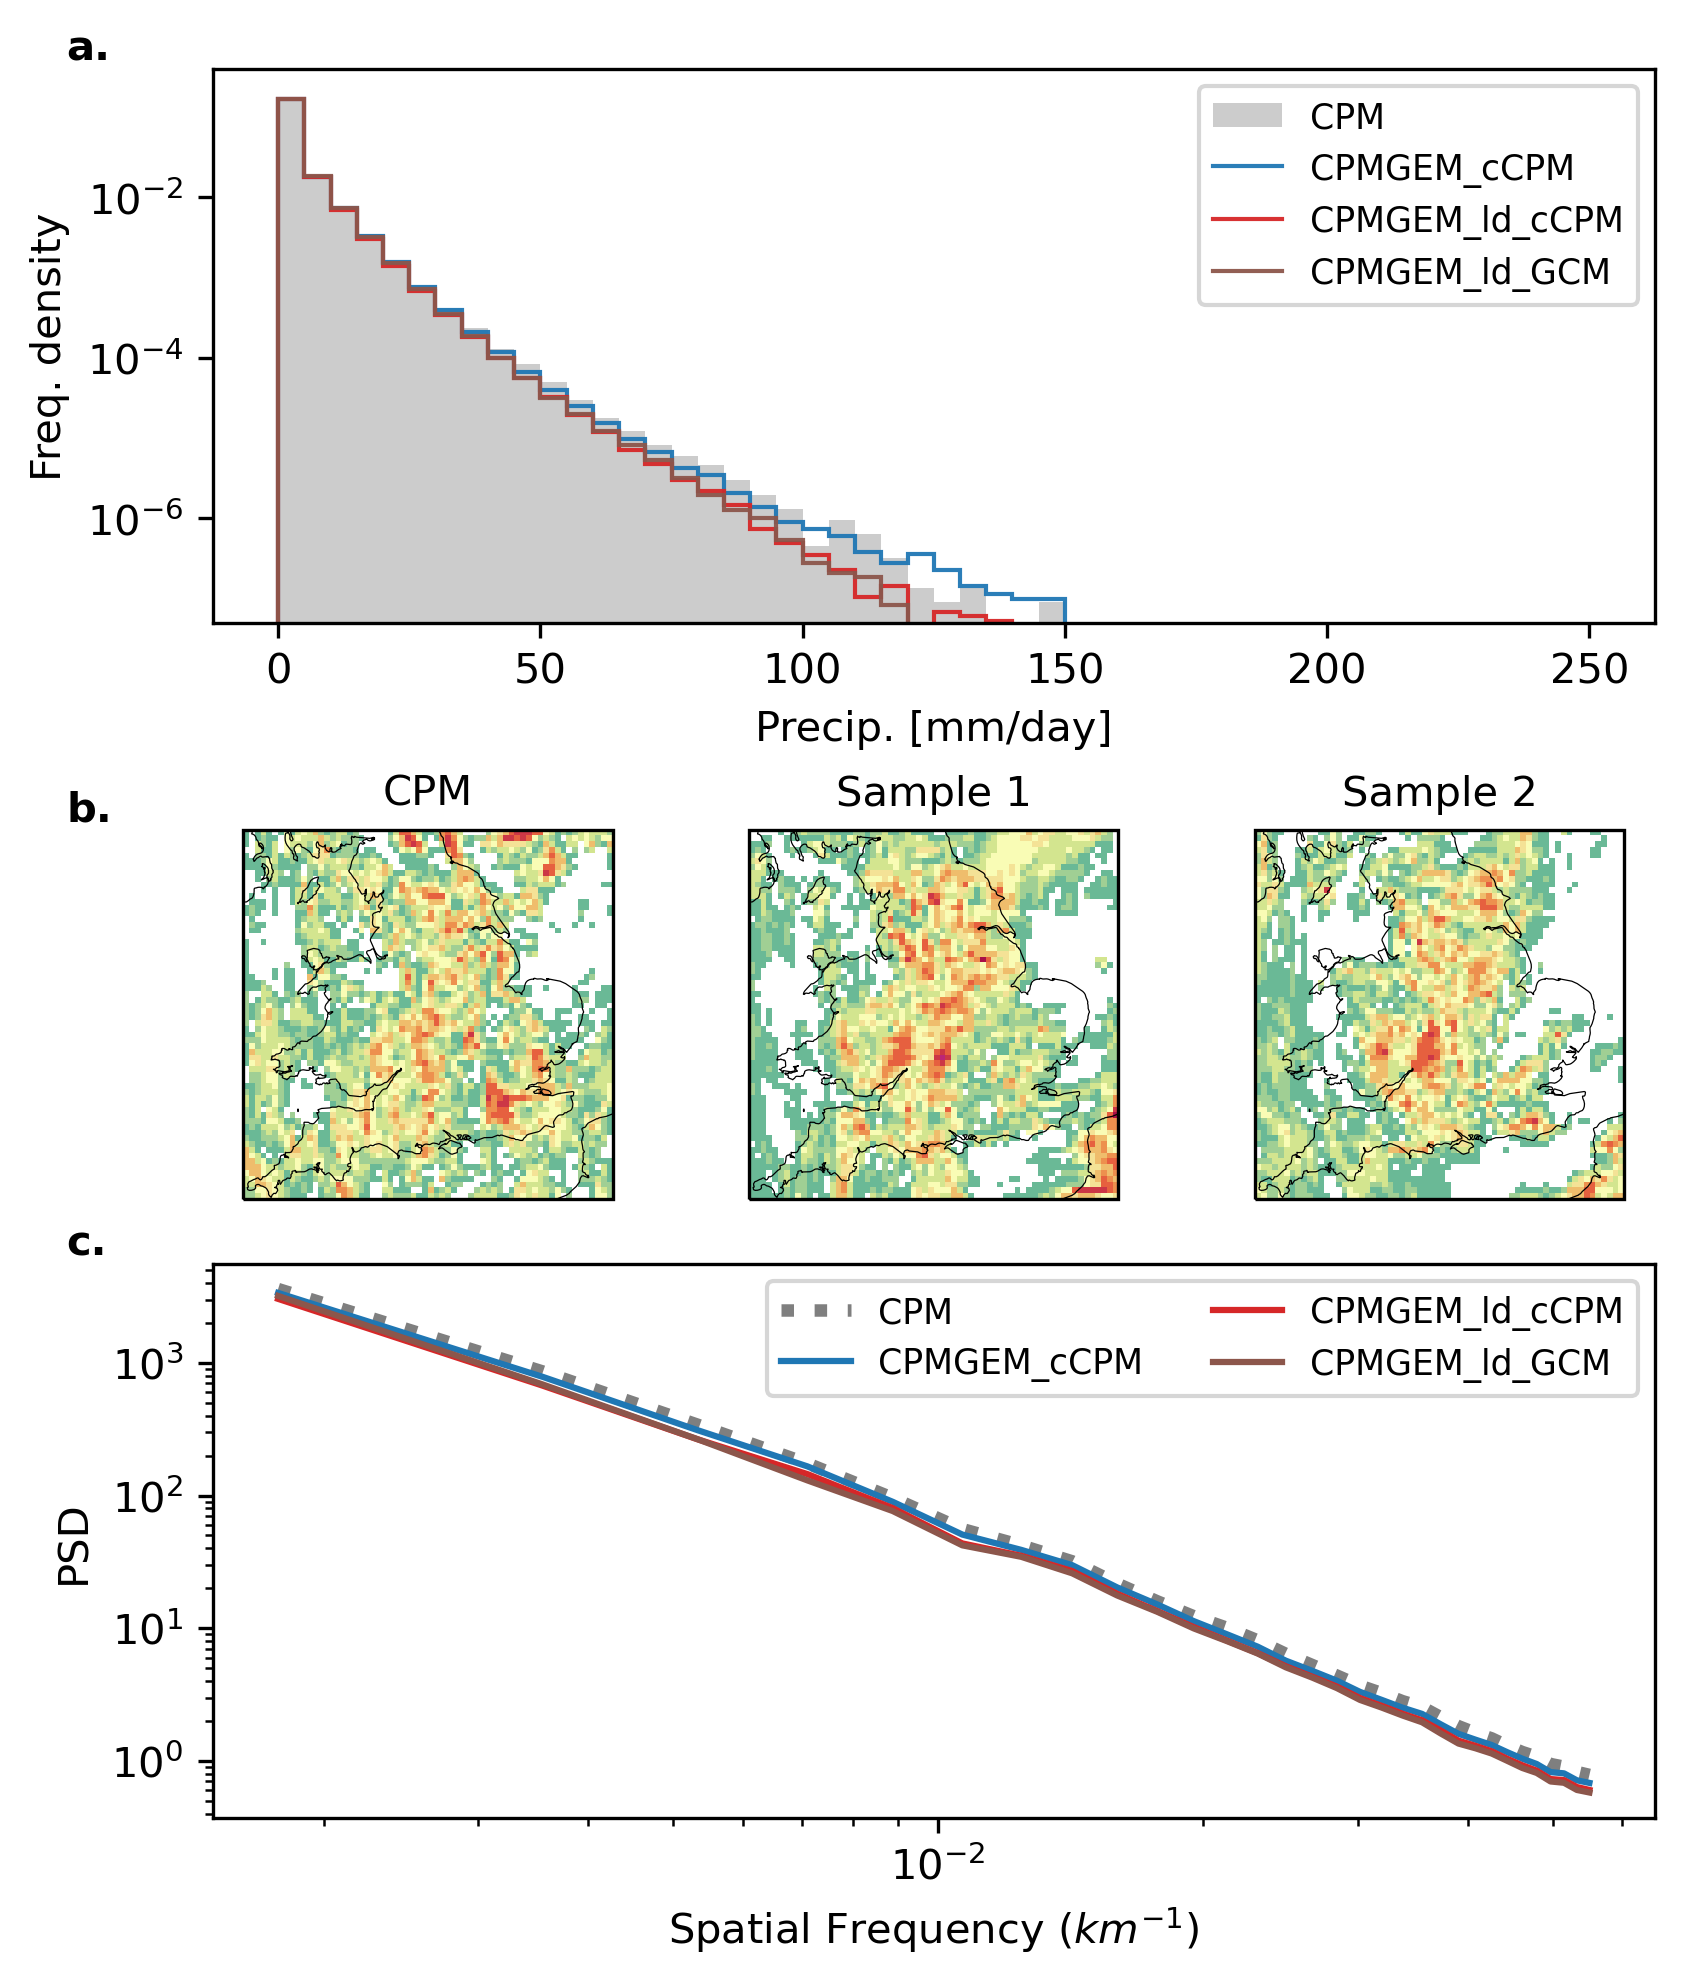

In [ ]:
fig = plt.figure(layout='constrained', figsize=(5.5, 6.5))

samples_to_show = 2

em_ts = {
    # ("01", "2029-12-04"),
    "": ("01", cftime.Datetime360Day(1993, 8, 1, 12)),
    # "JJA Wettest": ("01", "2073-07-30")
}

models_for_samples = [model for source, mspec in MODELS.items() for model, mconfig in mspec.items() if mconfig.get("Samples", False)]
sample_axes_keys = np.array([[f"CPM {em_ts_key}"] + [f"{model} {em_ts_key} sample {sidx}" for sidx in range(samples_to_show)] for model in models_for_samples for em_ts_key in (em_ts.keys())])
sample_spec = np.array(sample_axes_keys).reshape(len(models_for_samples) * len(em_ts),-1)

dist_spec = np.array(["Density"] * sample_spec.shape[1]).reshape(1,-1)

rapsd_spec = np.array(["RAPSD"] * sample_spec.shape[1]).reshape(1,-1)

spec = np.concatenate([dist_spec, sample_spec, rapsd_spec], axis=0)

axd = fig.subplot_mosaic(spec, gridspec_kw=dict(height_ratios=[3, 2, 3]), per_subplot_kw={ak: {"projection": cp_model_rotated_pole} for ak in sample_axes_keys.flat})

ax = axd["Density"]

plot_freq_density(hist_data, target_da=cpm_pr, ax=ax, linewidth=1, hrange=(0, 250))
ax.annotate("a.", xy=(0.04, 1.0), xycoords=("figure fraction", "axes fraction"), weight='bold', ha="left", va="bottom")

for model in models_for_samples:
    for tsi, (desc, ts) in enumerate(em_ts.items()):
        pr_da = EVAL_DS["CPM"].sel(ensemble_member=ts[0]).sel(time=ts[1], method="nearest")["target_pr"]
        
        ax = axd[f"CPM {desc}"]
        plot_map(
            pr_da,
            ax,
            style="pr",
            add_colorbar=False,
        )
        ax.set_title("CPM", fontsize="medium")
        # label row
        ax.text(
            -0.1,
            0.5,
            desc,
            transform=ax.transAxes,
            ha="right",
            va="center",
            fontsize="medium",
            rotation=90,
        )
        # annotate row with identifier
        ax.annotate("b.", xy=(0.04, 1.0), xycoords=("figure fraction", "axes fraction"), weight='bold', ha="left", va="bottom")
        for sidx in range(2):
            print(f"Precip from EM{ts[0]} on {ts[1]}")
        
            ts_ds = EVAL_DS["CPM"].sel(ensemble_member=ts[0]).sel(time=ts[1], method="nearest")
    
            pr_da = ts_ds.sel(model=model).isel(sample_id=sidx)["pred_pr"]
            ax = axd[f"{model} {desc} sample {sidx}"]
            
            plot_map(
                pr_da,
                ax,
                style="pr",
                add_colorbar=False,
            )
            ax.set_title(f"Sample {sidx+1}", fontsize="medium")

ax = axd["RAPSD"]
plot_psd(cpm_hr_rapsd, pred_rapsds, ax=ax, legend_kwargs={"fontsize": "small"})
ax.annotate("c.", xy=(0.04, 1.0), xycoords=("figure fraction", "axes fraction"), weight='bold', ha="left", va="bottom")

In [ ]:
def rmmb(pred_pr):
    return rms_mean_bias(pred_pr, cpm_pr)
def rmsb(pred_pr):
    return rms_std_bias(pred_pr, cpm_pr)

rms_mean_biases = xr.concat([ EVAL_DS[source]["pred_pr"].groupby("model", squeeze=False).map(rmmb) for source in EVAL_DS.keys() ], dim="model")
rms_std_biases = xr.concat([ EVAL_DS[source]["pred_pr"].groupby("model", squeeze=False).map(rmsb) for source in EVAL_DS.keys() ], dim="model")

IPython.display.display_html(rms_mean_biases.rename("Root Mean Square Mean Bias (mm/day)").to_dataframe().round(2).to_html(), raw=True)
IPython.display.display_html(rms_std_biases.rename("Root Mean Square Std Dev Bias (mm/day)").to_dataframe().round(2).to_html(), raw=True)

,Root Mean Square Mean Bias (mm/day)
model,
CPMGEM_cCPM,0.15
CPMGEM_ld_cCPM,0.25
CPMGEM_ld_GCM,0.18


,Root Mean Square Std Dev Bias (mm/day)
model,
CPMGEM_cCPM,0.37
CPMGEM_ld_cCPM,0.56
CPMGEM_ld_GCM,0.55
